In [241]:
import random
import numpy as np
import cec2017.functions as functions
import copy

In [242]:
Dim = 30
NP = 10
bound = 100

In [243]:
X = np.random.uniform(low=-bound, high=bound, size=Dim)
X_min = X.min()
X_max = X.max()
X_list = np.empty([NP, Dim])
for i in range(NP):
    for j in range(Dim):
        X_list[i][j] = X_min + random.uniform(0, 1) * (X_max - X_min)

X_list

array([[-80.17383239, -79.55960001,   5.82370064, -71.68765087,
        -52.08137359,  57.08892583,   0.82136083, -18.59364113,
        -92.77823065, -75.52707797, -45.99769177,  62.35067837,
          0.47083654,  36.1686615 ,  -8.26246774, -39.20970909,
         84.99552533, -85.83207003, -62.17732831,  -5.19968054,
         12.51478033,  78.59214482, -37.59494199,  30.50102344,
          9.60456023, -58.39750653, -26.60693509, -54.14935995,
        -58.27939366,  24.62687169],
       [ 91.6105328 ,  62.56214389, -50.85079341, -68.50172407,
        -11.21690608, -47.96493971,  60.20563601, -67.15181612,
         70.73765494,  78.18758656,  38.77165509,  -6.81062331,
        -32.28391794, -79.85923514, -74.04907759,  68.09206771,
        -95.32654506,  16.86245121,  72.15012367,  68.50937789,
         65.63226918, -41.42764311, -81.22358254,  66.93991234,
         46.65910191, -82.29035742, -44.45002574,  52.3531541 ,
         69.10183882, -64.72185045],
       [-31.30406934,  44.5213

In [244]:
""":parameter for DE"""
T_DE = 100
no = 5
CR = 0.9  # rate of crossover

""":parameter for MMS"""
mms_e = 0.000001
mms_F = 0.5

In [245]:
""":parameter k and F: for current/rand/1"""
k = 0.3
F = 0.5

In [246]:
""":parameter for crossoverSBX"""
sbx_n = 10

In [247]:
# f = functions.f1

In [248]:
def feas(x):
    if x.max() <= bound and x.min() >= -bound:
        return 1
    else:
        return 0

In [249]:
def select_better_fit(x1, x2, f):
    if f(x1) <= f(x2):
        return x1
    else:
        return x2

In [250]:
def current_to_rand(x_list, r1, r2, r3, i):
    return np.add(x_list[i], k * np.subtract(x_list[r1], x_list[i]), F * np.subtract(x_list[r2], x_list[r3]))

In [251]:
def immsade(xx_list, r1, r2, r3):
    immsade_omega = random.uniform(0.7, 1.0)
    immsade_F = random.uniform(0.5, 0.8)
    v_delta = np.add(np.multiply(immsade_omega, xx_list[r1]),
                     immsade_F * np.subtract(xx_list[r2], xx_list[r3]))
    v_delta = np.maximum(v_delta, -100)
    v_delta = np.minimum(v_delta, 100)
    return v_delta

In [252]:
def crossover_SBX(x_i, v_j, f):
    beta = 0
    while isinstance(beta, complex):
        sbx_rand = random.random()
        if sbx_rand <= 0.5:
            beta = (2 * sbx_rand) ** (1 / (1 + sbx_n))
        else:
            beta = (1 / (2 - sbx_n * 2)) ** (1 / (1 + sbx_n))

    c1 = 0.5 * np.add((1 + beta) * x_i, (1 - beta) * v_j)  # crossover
    c2 = 0.5 * np.add((1 - beta) * x_i, (1 + beta) * v_j)
    return select_better_fit(c1, c2, f)

In [253]:
def DE(f):
    x_list = copy.deepcopy(X_list)
    x_best = x_list[0]
    # print(x_list[0])

    t = 1
    while t <= T_DE:
        for i in range(NP):
            u_best = np.empty([Dim])
            for j in range(Dim):
                r_list = random.sample(range(NP), 5)
                for m in range(no):
                    while r_list[m] == i:
                        # r_list[m] = random.randint(0, Dim - 1)
                        r_list[m] = random.randint(0, NP - 1)

                v_j = np.empty([Dim])
                v_j = immsade(x_list, r_list[1], r_list[2], r_list[3])

                cr_rand = random.random()
                if cr_rand <= CR:
                    u_j = crossover_SBX(x_list[i], v_j, f)
                else:
                    u_j = x_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(x_list[i]) and feas(u_best) == 1:
                    x_list[i] = u_best

                if f(x_list[i]) < f(x_best) and feas(x_list[i]) == 1:
                    x_best = x_list[i]

        t += 1
    return x_best


In [254]:
""":parameter: for AGDE"""
T_AGDE = 100

In [255]:
def index_of_X_best(xx_list, f):
    index = 0
    min_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) < min_fit:
            index = i
            min_fit = f(xx_list[i])
    return index


def index_of_X_worst(xx_list, f):
    index = 0
    max_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) > max_fit:
            index = i
            max_fit = f(xx_list[i])
    return index


def compare_max(delta):
    """
    lower bound
    :param delta: delta
    :return: turn into lower bound delta
    """

    em = np.linspace(-100, -100, Dim)
    delta = np.maximum(delta, em)
    return delta


def compare_min(delta):
    on = np.linspace(100, 100, Dim)
    delta = np.minimum(delta, on)
    # for i in range(len(delta)):
    #     delta[i] = min(delta[i], 1)
    return delta

def agde(xx_list, agde_F, agde_p, f):
    agde_NP = max(int(NP * agde_p), 0)
    r_list = random.randint(max(agde_NP * 2 - 1, 0), NP - 1)
    if max(agde_NP, 0) >= max(agde_NP * 2 - 1, 1):
        m = max(agde_NP, 0) + 1
    else:
        m = max(agde_NP * 2 - 1, 1)
    x_p_worst = xx_list[index_of_X_worst(xx_list[max(agde_NP, 0): m], f)]
    x_p_best = xx_list[index_of_X_best(xx_list[: max(agde_NP - 1, 1)], f)]
    v_delta = np.add(xx_list[r_list], np.multiply(agde_F, np.subtract(x_p_best, x_p_worst)))
    return v_delta

In [256]:
def AGDE(f):
    xx_list = copy.deepcopy(X_list)
    x_best = xx_list[0]
    # print(xx_list[0])

    G = 0
    p_j = 0.5
    s_j_sum = 0
    while G <= T_AGDE:  # iteration of DE
        n_s_j = 0
        f_j = 1
        for i in range(NP):  # iteration of generation
            agde_F = random.uniform(0.1, 1)
            Cr = 0
            if G == 1:
                if random.uniform(0, 1) <= 0.5:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            else:
                if random.uniform(0, 1) <= p_j:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            j_random = random.randint(1, NP)

            u_best = np.empty([Dim])
            for j in range(Dim):
                vj = agde(xx_list, agde_F, p_j, f)
                vj = compare_max(vj)
                vj = compare_min(vj)
                if random.uniform(0, 1) < Cr or j == j_random:
                    u_j = crossover_SBX(xx_list[i], vj, f)
                else:
                    u_j = xx_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(xx_list[i]) and feas(u_best) == 1:
                    xx_list[i] = u_best

                if f(xx_list[i]) < f(x_best) and feas(xx_list[i]) == 1:
                    x_best = xx_list[i]

        G += 1

        s_j = n_s_j / (n_s_j + f_j) + 0.01
        s_j_sum += s_j
        p_s_j = s_j / s_j_sum
        if (((G - 1) * p_j + p_s_j) / G) < 0.5:
            p_j = ((G - 1) * p_j + p_s_j) / G

    return x_best

In [257]:
""":parameter: for GSK"""
T_GSK = 100
GSK_p = 0.1
k_f = 0.01   # 0.5
k_r = 0.1   # 0.9
K = 10

In [258]:
def junior(xx_list, r, i, f):
    if random.uniform(0, 1) <= k_r:
        if f(xx_list[i]) > f(xx_list[r]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[r], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[i], xx_list[r])))
    else:
        v_delta = xx_list[i]
    return v_delta


def senior(xx_list, i, D_junior, f):
    if random.uniform(0, 1) <= k_r:
        D_senior = NP - D_junior
        NP_1 = int(D_senior * GSK_p)
        r_list = random.randint(D_junior - 1 + NP_1 * 2, NP - 1)
        if max(D_junior - 1 + NP_1, 0) >= max(D_junior - 1 + NP_1 * 2 - 1, 1):
            m = max(D_junior - 1 + NP_1, 0) + 1
        else:
            m = max(D_junior - 1 + NP_1 * 2 - 1, 1)
        if max(D_junior - 1, 0) >= max(D_junior - 1 + NP_1 - 1, 1):
            n = max(D_junior - 1, 0) + 1
        else:
            n = max(D_junior - 1 + NP_1 - 1, 1)
        x_p_worst = xx_list[index_of_X_worst(xx_list[max(D_junior - 1 + NP_1, 0): m], f)]
        x_p_best = xx_list[index_of_X_best(xx_list[max(D_junior - 1, 0): n], f)]
        if f(xx_list[i]) > f(xx_list[r_list]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[r_list], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[i], xx_list[r_list])))
    else:
        v_delta = xx_list[i]
    return v_delta


In [259]:
def GSK(f):
    """
    DE algorithm
    :param x_list:
    :return: best x by DE
    """
    xxx_list = copy.deepcopy(X_list)

    x_best = xxx_list[0]
    # print(xxx_list[0])
    G = 0

    while G <= T_GSK:  # iteration of DE
        D_junior = int(NP * pow((1 - G / T_GSK), K))

        for i in range(NP):  # iteration of generation

            u_best = np.empty([Dim])
            for j in range(NP):
                vj = np.empty([Dim])
                r = random.randint(0, NP - 1)
                if j <= D_junior:
                    vj = junior(xxx_list, r, j, f)
                else:
                    vj = senior(xxx_list, j, D_junior, f)

                vj = compare_max(vj)
                vj = compare_min(vj)

                if j == 0:
                    u_best = vj
                else:
                    u_best = select_better_fit(u_best, vj, f)

                if f(u_best) <= f(xxx_list[i]) and feas(u_best) == 1:
                    xxx_list[i] = u_best

                if f(xxx_list[i]) < f(x_best) and feas(xxx_list[i]) == 1:
                    x_best = xxx_list[i]

        G += 1

    return x_best


In [260]:
import os
test_list = np.empty([len(functions.all_functions), 3])
test_path = r'D:\profile\codes\python_projects\ocp\test\output\D30_cpu'
for i in range(1, 52):
    j = 0
    for f in functions.all_functions:
        x_best_DE_fit = 0
        x_best_AGDE_fit = 0
        x_best_GSK_fit = 0
        x_best_DE_fit = f(DE(f))
        x_best_AGDE_fit = f(AGDE(f))
        x_best_GSK_fit = f(GSK(f))
        print(f.__name__, x_best_DE_fit, x_best_AGDE_fit, x_best_GSK_fit, "\n")
        test_list[j][0] = x_best_DE_fit
        test_list[j][1] = x_best_AGDE_fit
        test_list[j][2] = x_best_GSK_fit
        j += 1

    np.savetxt(os.path.join(test_path, str(i) + ".txt"), test_list)




f1 421053526281.0209 555148958706.2307 1294318302536.5198 

f2 2.171961762147072e+46 6.91414287193953e+51 5.7260648023608425e+51 

f3 109097.21990662231 283696.945725606 185272517.9912109 

f4 14434.105798185734 55619.27559641542 72756.8820228988 

f5 877.556841085084 1006.8751620570335 1155.1077567394307 

f6 715.407135668381 729.5854486119676 810.241140658853 

f7 1347.4839860578945 1881.62762760518 2877.023240668623 

f8 1138.6342232687798 1299.5450916707848 1469.3195336825484 

f9 6694.2984135491615 11327.193600864124 28809.71387892537 

f10 8290.33695506124 10156.255936535304 12183.984174521698 

f11 11937.656328454183 28784.647613368175 7272068.687283905 

f12 38409481444.58214 192574254997.63785 317532258862.1094 

f13 105574015444.5168 160187496915.43396 308099131861.7032 

f14 236645.85782600197 958191.360841669 11651163.59736725 

f15 433319101.66726136 103434122528.5301 151421717601.8351 

f16 4486.869420213996 11325.72715885118 12472.00137729969 



c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\basic.py:227: RuntimeWarning: invalid value encountered in true_divide
  t = np.abs(tjx - np.round(tjx)) / tj


f17 nan nan nan 

f18 31885906.605626196 245065571.866299 1650319920.85798 

f19 5308747720.072909 6088047440.246275 69537970920.84312 

f20 nan nan nan 

f21 2731.0384017357037 2963.7017278624335 3029.090903961813 

f22 6982.31339315888 10364.153045120696 13017.574295405015 

f23 3651.9354183850237 4554.724942169663 4875.487800731953 

f24 4029.2151170519655 4407.014224759879 5197.146619279786 

f25 6858.796091857683 13217.346663516872 25014.233712710866 

f26 11861.315120331848 15061.904114915578 16821.769983101145 

f27 4915.102484316041 5573.180512100077 5435.871017251797 

f28 7654.119349917508 14207.664124719766 18327.082692755503 

f29 nan nan nan 

f30 1496466625.6632586 42446723815.52906 74142800970.73628 

f1 432152018206.20087 561975511462.3323 1294318302536.5198 

f2 1.523547645135788e+47 8.75120623442824e+50 7.157675561938393e+51 

f3 107695.1235776868 139724.14566296083 104222064.78918904 

f4 18268.401205336668 58954.95599661143 72756.8820228988 

f5 911.184413454205 103

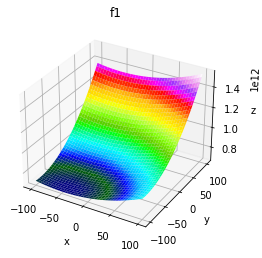

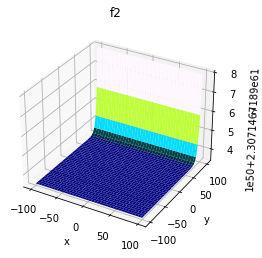

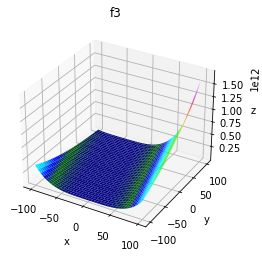

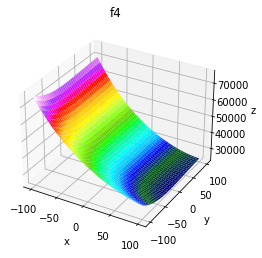

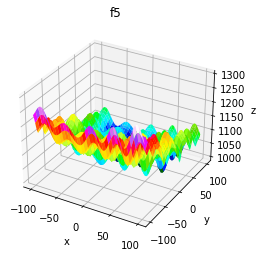

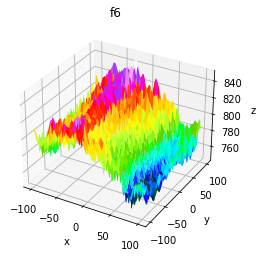

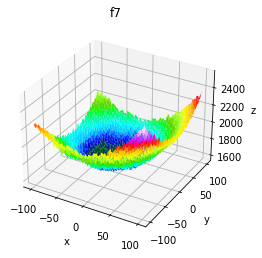

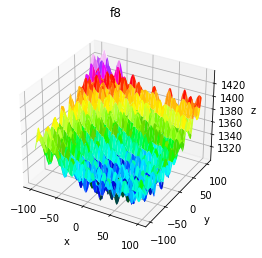

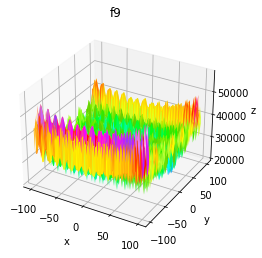

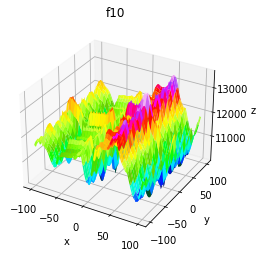

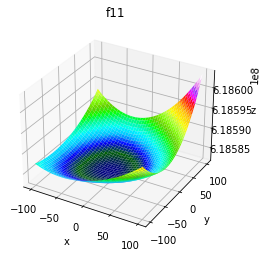

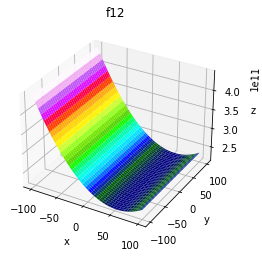

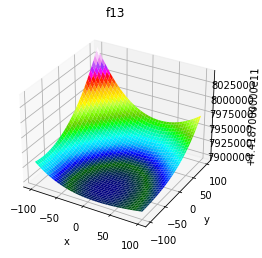

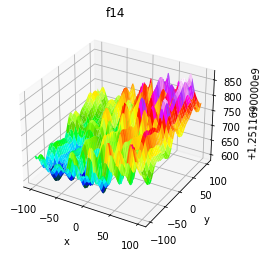

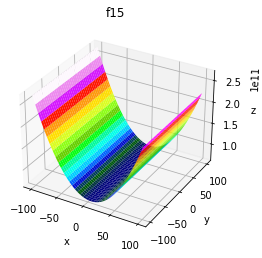

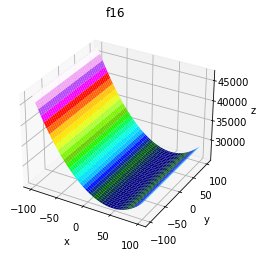

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\basic.py:227: RuntimeWarning: invalid value encountered in true_divide
  t = np.abs(tjx - np.round(tjx)) / tj
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\utils.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, cmap='gist_ncar', edgecolor='none')


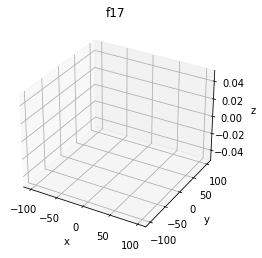

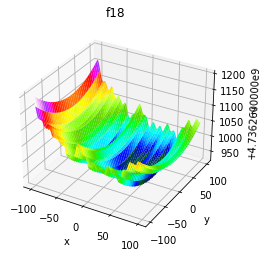

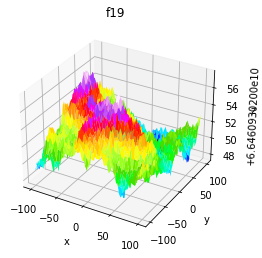

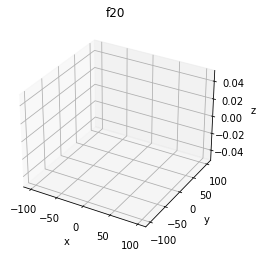

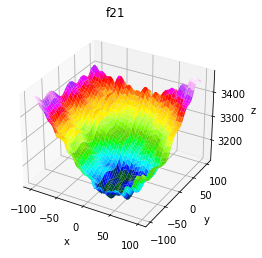

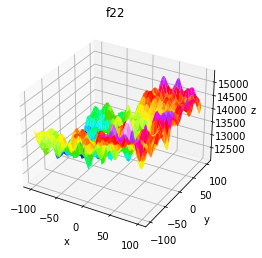

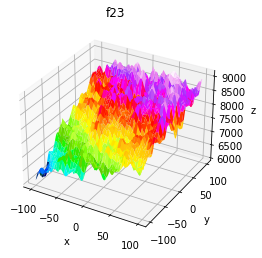

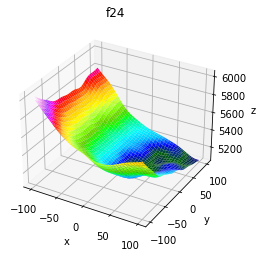

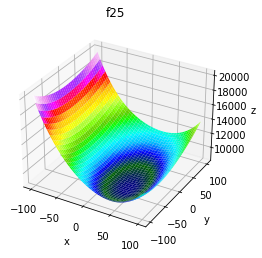

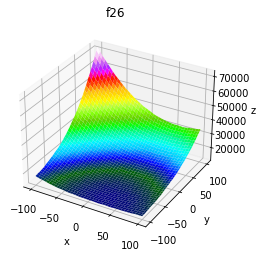

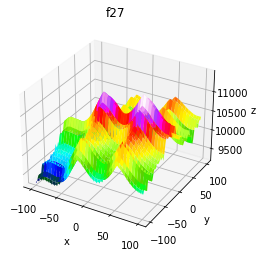

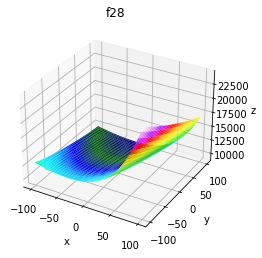

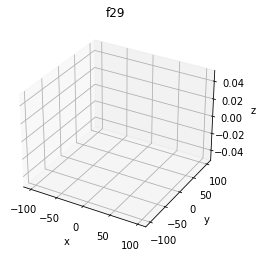

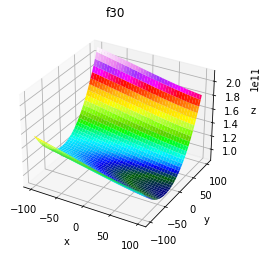

In [261]:
import cec2017.utils as utils
for f in functions.all_functions:
    utils.surface_plot(f, points=120, dimension=Dim)